# Nenana Ice Classic - Decision Trees Modeling

In [1]:
# imports

import numpy as np
import pandas as pd

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from mlxtend.plotting import plot_decision_regions

# pipeline and preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from category_encoders import WOEEncoder, OneHotEncoder
from sklearn.decomposition import KernelPCA as KPCA
from sklearn.model_selection import train_test_split, GridSearchCV

# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

# evaluation
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, cross_validate, cross_val_predict
from sklearn import metrics # explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
#from sklearn.utils import check_arrays # converts list-like objects to array (if needed)

# import datetime # didn't need after all

# Pretty Print to make some outputs easier to read
import pprint

# filter warnings
import warnings
warnings.filterwarnings("ignore")

import gc # garbage collection

rng = np.random.RandomState(42)

## Helper Functions

In [2]:
from sklearn.base import TransformerMixin


class ForestEncoder(TransformerMixin):
    
    def __init__(self, forest):
        self.forest = forest
        self.n_trees = 1
        try:
            self.n_trees = self.forest.n_estimators
        except:
            pass
        self.ohe = OneHotEncoder(cols=range(self.n_trees), use_cat_names=True)
        
    def fit(self, X, y=None):
        self.forest.fit(X, y)
#         self.ohe.fit(self.forest.apply(X)[:,:,0])
        self.ohe.fit(self.forest.apply(X))
        return self
    
    def transform(self, X, y=None):
#         return self.ohe.transform(self.forest.apply(X)[:,:,0])
        return self.ohe.transform(self.forest.apply(X))


In [3]:
def stringify(data):
    data = pd.DataFrame(data)
    for c in data.columns.tolist():
        data[c] = data[c].astype(str)
    return data

In [4]:
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)

In [5]:
sns.set_style("whitegrid", {'axes.grid' : False})

In [6]:
df = pd.read_csv('../data/features_added.csv')

In [7]:
df.head()

,Date,moonPhase,humidity,windSpeed,windBearing,uvIndex,temperatureMin,temperatureMax,precipIntensity,precipAccumulation,...,numColdDays_MA-accel5,numColdDays_MA-std_dev5,numColdDays_MA7,numColdDays_MA-slope7,numColdDays_MA-accel7,numColdDays_MA-std_dev7,numColdDays_MA10,numColdDays_MA-slope10,numColdDays_MA-accel10,numColdDays_MA-std_dev10
0,1989-03-01,0.80,0.70,8.42,236.0,1.0,20.58,29.65,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1989-03-02,0.83,0.68,8.59,266.0,1.0,-7.38,29.07,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1989-03-03,0.87,0.50,5.84,344.0,1.0,-19.23,1.84,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1989-03-04,0.90,0.51,2.52,6.0,1.0,-30.34,4.69,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1989-03-05,0.94,0.56,1.76,216.0,1.0,-38.53,0.74,0.0,0.0,...,0.714286,1.30384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Modeling

#### How good does my model have to be?

In [8]:
# the thing to beat: 0.9827072152653548
print('Percentage of non-events:')
1 - (df['winningDate'].sum()/df['winningDate'].count())

Percentage of non-events:


0.9827072152653548

#### Drop columns that are highly correlated
* temperatureMin and temperatureMax information was captured in temperatureAvg
* precipAccumulation information was captured in accumulatedSnow

In [9]:
df.drop(columns = ['temperatureMin', 'temperatureMax', 'precipAccumulation'],
        inplace = True)

#### Create training and testing DataFrames

In [10]:
train = df.loc[df['past'] == 1]
train.drop(columns = ['past', 'future'], inplace = True)

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1399 entries, 0 to 1398
Columns: 162 entries, Date to numColdDays_MA-std_dev10
dtypes: float64(154), int64(6), object(2)
memory usage: 1.7+ MB


In [12]:
test = df.loc[df['future'] == 1]
test.drop(columns = ['past', 'future'], inplace = True)

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278 entries, 1399 to 1676
Columns: 162 entries, Date to numColdDays_MA-std_dev10
dtypes: float64(154), int64(6), object(2)
memory usage: 354.0+ KB


In [14]:
df.drop(columns = ['past', 'future'], inplace = True)
gc.collect()

11

In [15]:
# columns to exclude from models (dates and target info)
exclude = ['winningTime', 'winningDate',  'Date']

In [16]:
used_cols = [c for c in train.columns if c not in exclude]

In [17]:
no_ma_cols = [c for c in train.columns.tolist() if not c.endswith(('3', '5', '7', '10'))]
used_no_ma_cols = [c for c in no_ma_cols if c not in exclude]

In [18]:
pprint.pprint(no_ma_cols)
pprint.pprint(used_no_ma_cols)

['Date',
 'moonPhase',
 'humidity',
 'windSpeed',
 'windBearing',
 'uvIndex',
 'precipIntensity',
 'winningTime',
 'daylightHours',
 'iceThickness',
 'dayOfYear',
 'winningDate',
 'precip_rain',
 'precip_snow',
 'temperatureAvg',
 'numHotDays',
 'numColdDays',
 'accumulatedSnow']
['moonPhase',
 'humidity',
 'windSpeed',
 'windBearing',
 'uvIndex',
 'precipIntensity',
 'daylightHours',
 'iceThickness',
 'dayOfYear',
 'precip_rain',
 'precip_snow',
 'temperatureAvg',
 'numHotDays',
 'numColdDays',
 'accumulatedSnow']


In [19]:
train.dropna(inplace = True)

In [20]:
test.dropna(inplace = True)

In [21]:
gc.collect()

0

In [22]:
target = 'winningDate'

---
### Decision Tree Model Excluding Moving Average Features

In [23]:
dt = DecisionTreeClassifier(criterion='entropy',
                            max_depth=4,
                            min_samples_leaf=5,
                            random_state=42,
                            class_weight='balanced')

X_train, y_train = train[used_no_ma_cols], train[target]

scores = cross_validate(dt, X_train, y_train, cv = TimeSeriesSplit(),
                        scoring=['f1', 'f1_weighted', 'precision', 'precision_weighted',
                                 'recall', 'recall_weighted', 'accuracy', 'roc_auc'])

print('f1:', scores['test_f1'].mean(), '+/-', scores['test_f1'].std())
print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision:', scores['test_precision'].mean(), '+/-', scores['test_precision'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall:', scores['test_recall'].mean(), '+/-', scores['test_recall'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

# the thing to beat: 0.9827072152653548 accuracy

# performance
# f1: 0.20142084882129724 +/- 0.08704315878839691
# f1_weighted: 0.943729060384207 +/- 0.009656803434700094
# precision: 0.1283397974574445 +/- 0.05717166158753391
# precision_weighted: 0.9716341828369274 +/- 0.0051816815986138
# recall: 0.48999999999999994 +/- 0.22891046284519195
# recall_weighted: 0.9222269899163269 +/- 0.01597510472903257
# accuracy: 0.9222269899163269 +/- 0.01597510472903257
# roc_auc: 0.7133351992834752 +/- 0.11100483884498065

f1: 0.19096654680178707 +/- 0.04114568615191551
f1_weighted: 0.9445674227004865 +/- 0.008080880980218903
precision: 0.1265204678362573 +/- 0.018560135856217897
precision_weighted: 0.9686489684382966 +/- 0.006881514681462991
recall: 0.44000000000000006 +/- 0.19849433241279207
recall_weighted: 0.9258883248730964 +/- 0.016557874548527998
accuracy: 0.9258883248730964 +/- 0.016557874548527998
roc_auc: 0.6910924006908463 +/- 0.09247258191476308


In [24]:
dt.fit(X_train, y_train)
X_test = test[used_no_ma_cols]
y_test = test[target]
y_pred = dt.predict(X_test)

In [25]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Test set balanced_accuracy:', metrics.balanced_accuracy_score(y_test, y_pred))

Test set accuracy: 0.9055793991416309
Test set balanced_accuracy: 0.5605263157894737


lorem ipsum

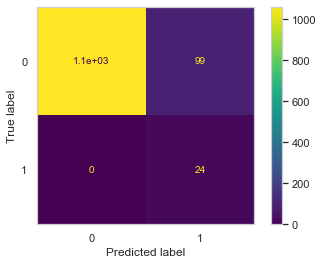

In [26]:
metrics.plot_confusion_matrix(dt, X_train, y_train);

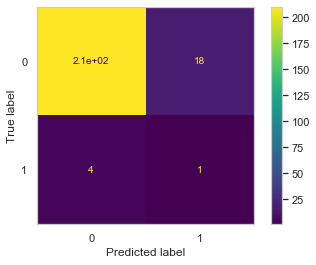

In [27]:
metrics.plot_confusion_matrix(dt, X_test, y_test);

lorem ipsum

In [28]:
y_pred = dt.predict_proba(X_test)[:,1]
y_pred[:5]

array([0., 0., 0., 0., 0.])

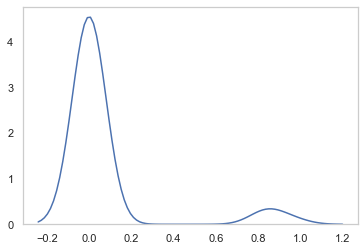

In [29]:
sns.kdeplot(y_pred);

In [30]:
metrics.confusion_matrix(y_test, y_pred > 0)

array([[210,  18],
       [  4,   1]])

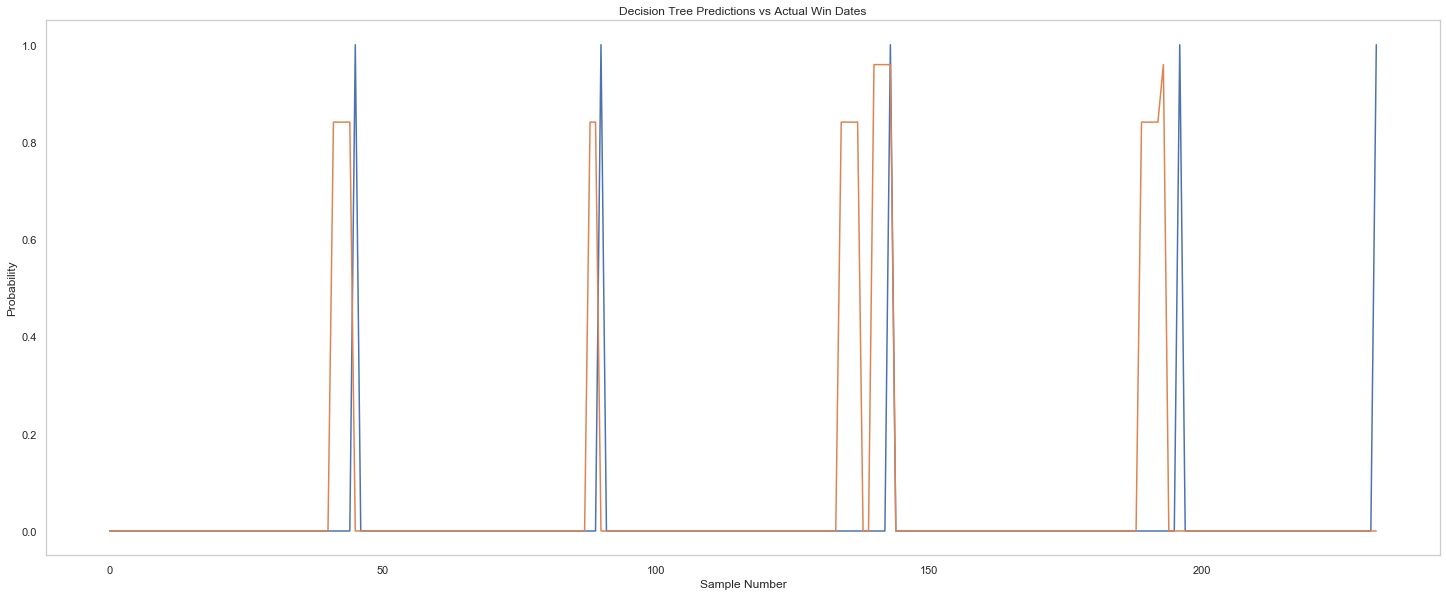

In [31]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Decision Tree Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

---
#### Decision Tree Including Moving Average Features

In [32]:
dt = DecisionTreeClassifier(criterion='entropy',
                            max_depth=4,
                            min_samples_leaf=5,
                            random_state=42,
                            class_weight='balanced')

X_train, y_train = train[used_cols], train[target]

scores = cross_validate(dt, X_train, y_train, cv = TimeSeriesSplit(),
                        scoring=['f1', 'f1_weighted', 'precision', 'precision_weighted',
                                 'recall', 'recall_weighted', 'accuracy', 'roc_auc'])

print('f1:', scores['test_f1'].mean(), '+/-', scores['test_f1'].std())
print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision:', scores['test_precision'].mean(), '+/-', scores['test_precision'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall:', scores['test_recall'].mean(), '+/-', scores['test_recall'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

# the thing to beat: 0.9827072152653548 accuracy

# performance
# f1: 0.22939068100358423 +/- 0.028251368069403936
# f1_weighted: 0.9390852534533538 +/- 0.016124144791608896
# precision: 0.15162962962962961 +/- 0.027713357399031878
# precision_weighted: 0.9733964417793496 +/- 0.0048817174710536594
# recall: 0.61 +/- 0.2615339366124404
# recall_weighted: 0.9147208121827409 +/- 0.028965162675506816
# accuracy: 0.9147208121827409 +/- 0.028965162675506816
# roc_auc: 0.7655650906735751 +/- 0.11409189218238967

f1: 0.22939068100358423 +/- 0.028251368069403936
f1_weighted: 0.9390852534533538 +/- 0.016124144791608896
precision: 0.15162962962962961 +/- 0.027713357399031878
precision_weighted: 0.9733964417793496 +/- 0.0048817174710536594
recall: 0.61 +/- 0.2615339366124404
recall_weighted: 0.9147208121827409 +/- 0.028965162675506816
accuracy: 0.9147208121827409 +/- 0.028965162675506816
roc_auc: 0.7655650906735751 +/- 0.11409189218238967


In [33]:
dt.fit(X_train, y_train)
X_test = test[used_cols]
y_test = test[target]
y_pred = dt.predict(X_test)

In [34]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Test set balanced_accuracy:', metrics.balanced_accuracy_score(y_test, y_pred))

Test set accuracy: 0.9227467811158798
Test set balanced_accuracy: 0.7649122807017543


lorem ipsum

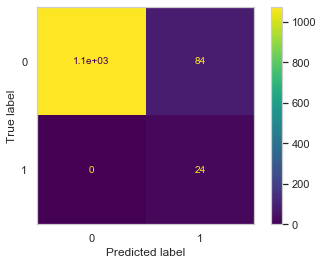

In [35]:
metrics.plot_confusion_matrix(dt, X_train, y_train);

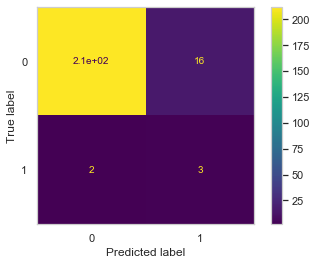

In [36]:
metrics.plot_confusion_matrix(dt, X_test, y_test);

lorem ipsum

In [37]:
y_pred = dt.predict_proba(X_test)[:,1]
y_pred[:5]

array([0., 0., 0., 0., 0.])

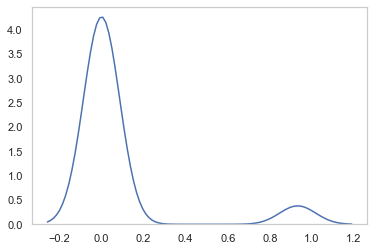

In [38]:
sns.kdeplot(y_pred);

In [39]:
metrics.confusion_matrix(y_test, y_pred > 0)

array([[212,  16],
       [  2,   3]])

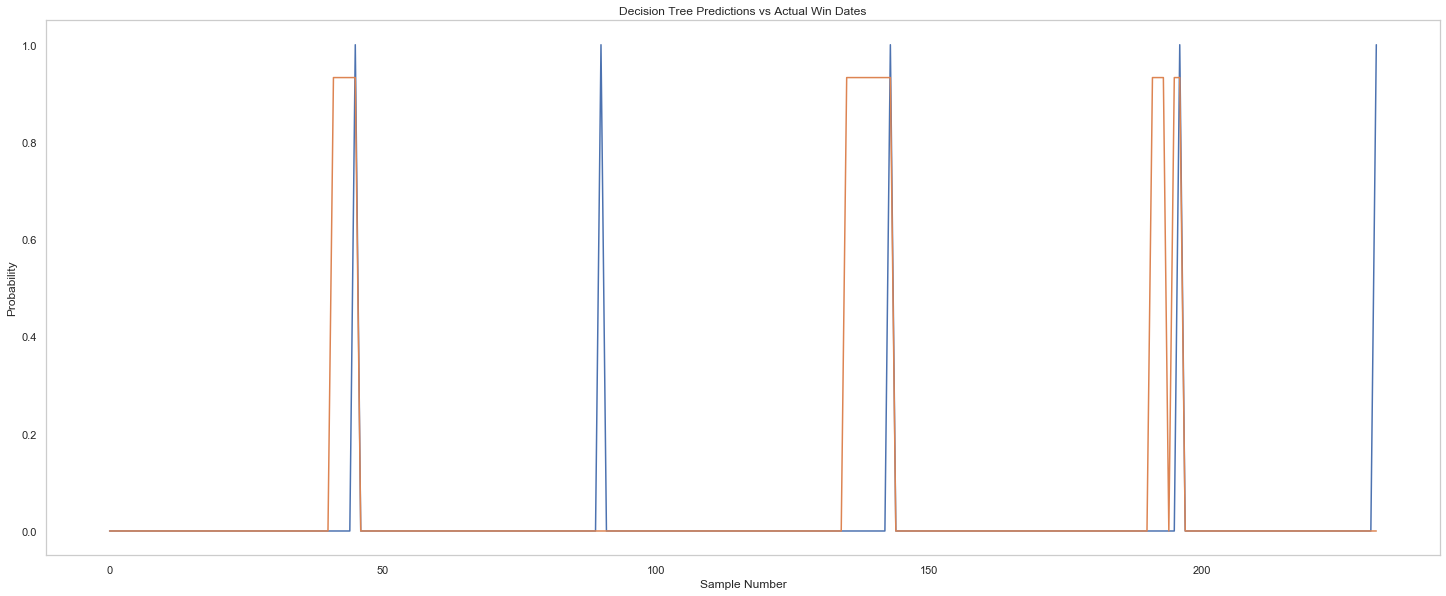

In [40]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Decision Tree Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

---
### Random Forest Model Excluding Moving Average Features

#### Grid search to find best parameters

In [55]:
rf = RandomForestClassifier(random_state = 42)

In [56]:
# grid_p = {"n_estimators": [20, 50, 100], # first run
# grid_p = {"n_estimators": [40, 50, 60], # second run
grid_p = {"n_estimators": [50, 60, 70], # third run
          "criterion": ["gini", "entropy"],
          "max_features": ['sqrt', 'log2', 0.2],
#           "max_depth": [4, 6, 10], # first run
#           "max_depth": [8, 10, 12], # second run
          "max_depth": [7, 8, 9], # third run
#           "min_samples_split": [2, 5, 10], # first run
          "min_samples_split": [1, 2, 3], # second run
          "min_samples_leaf": [1, 5, 10]}

grid_search = GridSearchCV(rf, grid_p, n_jobs=-1, cv=TimeSeriesSplit(), scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_f...
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_sta

In [57]:
grid_search.best_score_
# first run best = 0.9738471502590673
# second run best = 0.9756606217616579

0.9756606217616579

In [58]:
grid_search.best_params_
# first run
# {'criterion': 'entropy',
#  'max_depth': 10,
#  'max_features': 0.2,
#  'min_samples_leaf': 5,
#  'min_samples_split': 2,
#  'n_estimators': 50}

# second run
# {'criterion': 'entropy',
#  'max_depth': 8,
#  'max_features': 0.2,
#  'min_samples_leaf': 5,
#  'min_samples_split': 2,
#  'n_estimators': 60}

{'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 0.2,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 60}

In [59]:
best_rf = grid_search.best_estimator_

y_pred = best_rf.predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_test, y_pred)
# first run best = 0.9631578947368421
# second run best = 0.9675438596491228

0.9675438596491228

In [60]:
n_trees = best_rf.get_params()['n_estimators']

scores = cross_val_score(best_rf, X_train, y_train, cv=TimeSeriesSplit(), scoring='roc_auc') 
print(scores.mean(), "+/-", scores.std())
# first run: 0.9738471502590673 +/- 0.0075067421171112255
# second run: 0.9756606217616579 +/- 0.00944409789195802

0.9756606217616579 +/- 0.00944409789195802


In [61]:
encoder = ForestEncoder(best_rf)
clf = LogisticRegressionCV(class_weight='balanced', random_state = 42, n_jobs = -1, scoring = 'recall')
pipe = make_pipeline(encoder, clf)

scores = cross_val_score(pipe, X_train, y_train, cv=TimeSeriesSplit(), scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())
# first run: 0.9714594127806564 +/- 0.010449050086355797
# second run: 0.9715155440414508 +/- 0.012251749750802725

0.9715155440414508 +/- 0.012251749750802725


#### Create model using grid search parameters

In [62]:
rf = RandomForestClassifier(bootstrap = True,
                            class_weight = 'balanced',
                            criterion = 'entropy',
                            max_depth = 7,
                            max_features = 0.2,
                            min_samples_leaf = 5,
                            min_samples_split = 2,
                            n_estimators = 60,
                            n_jobs = -1, random_state = 42)

encoder = ForestEncoder(rf)

clf = LogisticRegressionCV(scoring = 'recall',
                           cv = TimeSeriesSplit(),
                           class_weight = 'balanced',
                           n_jobs = -1,
                           random_state = 42)

pipe = make_pipeline(encoder, clf)

X_train, y_train = train[used_no_ma_cols], train[target]

scores = cross_validate(pipe, X_train, y_train, cv = TimeSeriesSplit(),
                        scoring=['f1', 'f1_weighted', 'precision', 'precision_weighted',
                                 'recall', 'recall_weighted', 'accuracy', 'roc_auc'])

print('f1:', scores['test_f1'].mean(), '+/-', scores['test_f1'].std())
print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision:', scores['test_precision'].mean(), '+/-', scores['test_precision'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall:', scores['test_recall'].mean(), '+/-', scores['test_recall'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

# the thing to beat: 0.9827072152653548 accuracy

# performance
# f1: 0.22546536092404668 +/- 0.0588473148652274
# f1_weighted: 0.9098259417038855 +/- 0.032494765385307496
# precision: 0.1354791641658573 +/- 0.05043921643779009
# precision_weighted: 0.9798024360986091 +/- 0.0033881174473236594
# recall: 0.8800000000000001 +/- 0.16
# recall_weighted: 0.8629979260530642 +/- 0.05456088620415935
# accuracy: 0.8629979260530642 +/- 0.05456088620415935
# roc_auc: 0.955968987908643 +/- 0.01821025945518719

f1: nan +/- nan
f1_weighted: nan +/- nan
precision: nan +/- nan
precision_weighted: nan +/- nan
recall: nan +/- nan
recall_weighted: nan +/- nan
accuracy: nan +/- nan
roc_auc: nan +/- nan


In [63]:
pipe.fit(X_train, y_train)
X_test = test[used_no_ma_cols]
y_test = test[target]
y_pred = pipe.predict(X_test)

In [64]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Test set balanced_accuracy:', metrics.balanced_accuracy_score(y_test, y_pred))

Test set accuracy: 0.9313304721030042
Test set balanced_accuracy: 0.8671052631578948


lorem ipsum

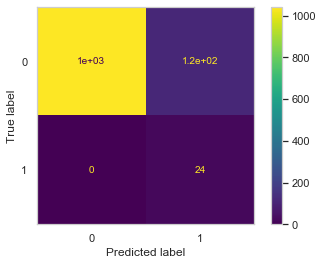

In [65]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

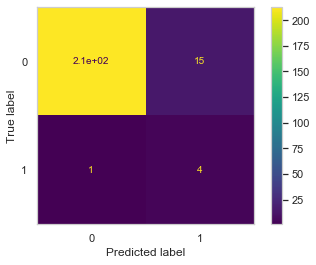

In [66]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

lorem ipsum

In [67]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([0.12160848, 0.12462226, 0.12462226, 0.11528339, 0.11855496])

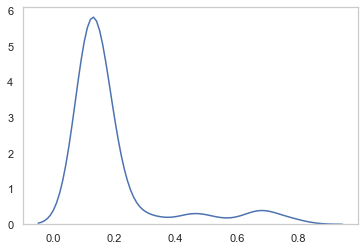

In [68]:
sns.kdeplot(y_pred);

In [69]:
metrics.confusion_matrix(y_test, y_pred > 0.356)

array([[205,  23],
       [  1,   4]])

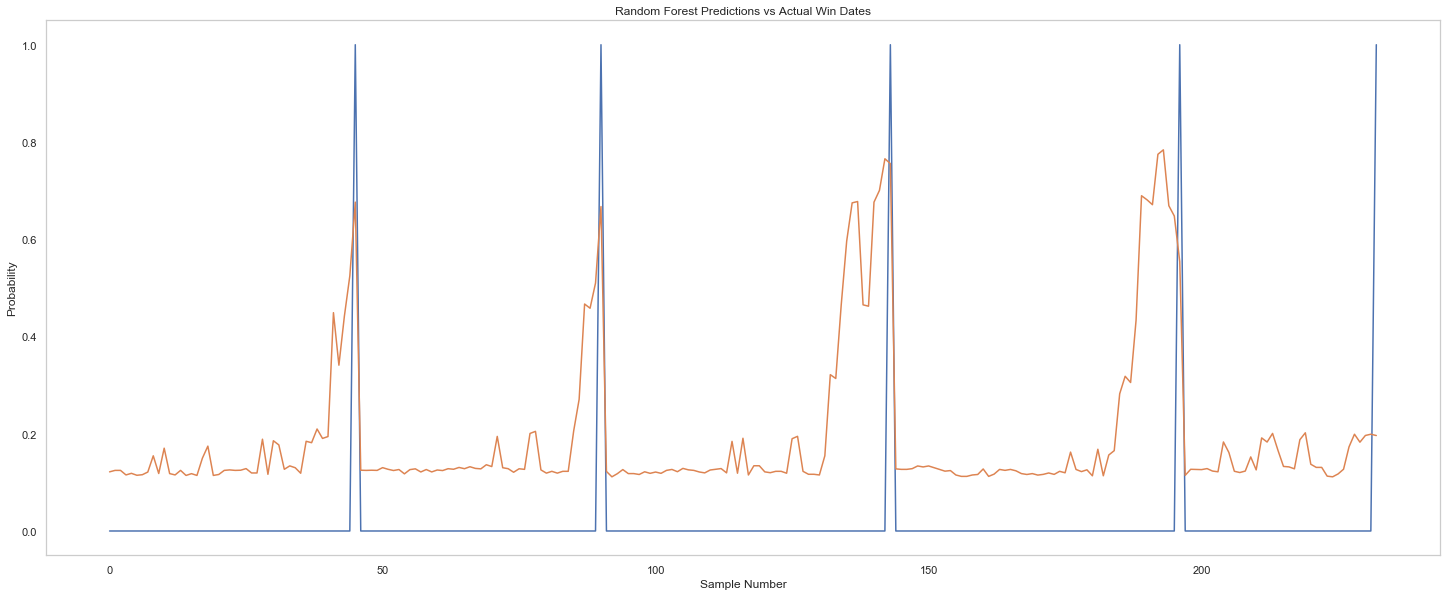

In [70]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Random Forest Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

---
### Random Forest Model Including Moving Average Features

#### Grid search to find best parameters

In [ ]:
# rf = RandomForestClassifier(random_state = 42)

In [ ]:
# # grid_p = {"n_estimators": [20, 50, 100], # first run
# # grid_p = {"n_estimators": [40, 50, 60], # second run
# grid_p = {"n_estimators": [50, 60, 70], # third run
#           "criterion": ["gini", "entropy"],
#           "max_features": ['sqrt', 'log2', 0.2],
# #           "max_depth": [4, 6, 10], # first run
# #           "max_depth": [6, 8, 10], # second run
#           "max_depth": [5, 6, 7], # third run
# #           "min_samples_split": [2, 5, 10], # first run
#           "min_samples_split": [1, 2, 3], # second run, third run
#           "min_samples_leaf": [1, 5, 10]}

# grid_search = GridSearchCV(rf, grid_p, n_jobs=-1, cv=TimeSeriesSplit(), scoring='roc_auc')
# grid_search.fit(X_train, y_train)

In [ ]:
# grid_search.best_score_

In [ ]:
# grid_search.best_params_

In [ ]:
# best_rf = grid_search.best_estimator_

# y_pred = best_rf.predict_proba(X_test)[:,1]
# metrics.roc_auc_score(y_test, y_pred)

In [ ]:
# n_trees = best_rf.get_params()['n_estimators']

# scores = cross_val_score(best_rf, X_train, y_train, cv=TimeSeriesSplit(), scoring='roc_auc') 
# print(scores.mean(), "+/-", scores.std())

In [ ]:
# encoder = ForestEncoder(best_rf)
# clf = LogisticRegressionCV(class_weight='balanced', random_state = 42, n_jobs = -1, scoring = 'recall')
# pipe = make_pipeline(encoder, clf)

# scores = cross_val_score(pipe, X_train, y_train, cv=TimeSeriesSplit(), scoring='roc_auc')
# print(scores.mean(), "+/-", scores.std())

#### Create model using grid search parameters

In [71]:
# BEST OVERALL MODEL

rf = RandomForestClassifier(bootstrap = True,
                            class_weight = 'balanced',
                            criterion = 'entropy',
                            max_depth = 6,
                            max_features = 'sqrt',
                            min_samples_leaf = 1,
                            min_samples_split = 2,
                            n_estimators = 60,
                            n_jobs = -1, random_state = 42)

encoder = ForestEncoder(rf)

clf = LogisticRegressionCV(class_weight = 'balanced',
                           random_state = 42,
                           cv = TimeSeriesSplit(),
                           n_jobs = -1,
                           scoring = 'recall')

pipe = make_pipeline(encoder, clf)

X_train, y_train = train[used_cols], train[target]

scores = cross_validate(pipe, X_train, y_train, cv = TimeSeriesSplit(),
                        scoring=['f1', 'f1_weighted', 'precision', 'precision_weighted',
                                 'recall', 'recall_weighted', 'accuracy', 'roc_auc'])

print('f1:', scores['test_f1'].mean(), '+/-', scores['test_f1'].std())
print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision:', scores['test_precision'].mean(), '+/-', scores['test_precision'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall:', scores['test_recall'].mean(), '+/-', scores['test_recall'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

# the thing to beat: 0.9827072152653548 accuracy

# performance
# f1: 0.3343267259056733 +/- 0.1046412766903022
# f1_weighted: 0.945138708701046 +/- 0.02491269989297263
# precision: 0.2209712867777384 +/- 0.08482194182677455
# precision_weighted: 0.9807909258765413 +/- 0.00451814146981348
# recall: 0.8400000000000001 +/- 0.19595917942265426
# recall_weighted: 0.92130086533648 +/- 0.04267989552894394
# accuracy: 0.92130086533648 +/- 0.04267989552894394
# roc_auc: 0.9632460068666966 +/- 0.0184745363959153

f1: nan +/- nan
f1_weighted: nan +/- nan
precision: nan +/- nan
precision_weighted: nan +/- nan
recall: nan +/- nan
recall_weighted: nan +/- nan
accuracy: nan +/- nan
roc_auc: nan +/- nan


In [72]:
pipe.fit(X_train, y_train)
X_test = test[used_cols]
y_test = test[target]
y_pred = pipe.predict(X_test)

In [73]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Test set balanced_accuracy:', metrics.balanced_accuracy_score(y_test, y_pred))

Test set accuracy: 0.9570815450643777
Test set balanced_accuracy: 0.8802631578947369


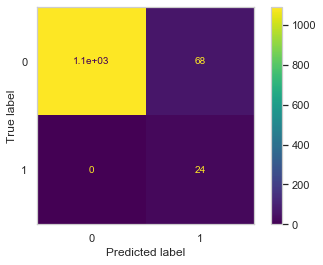

In [74]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

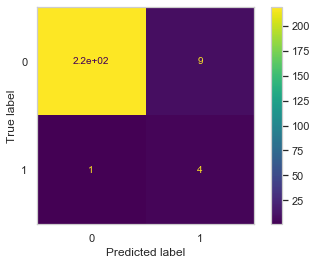

In [75]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [76]:
y_pred = rf.predict_proba(X_test)[:,1]
y_pred[:5]

array([0., 0., 0., 0., 0.])

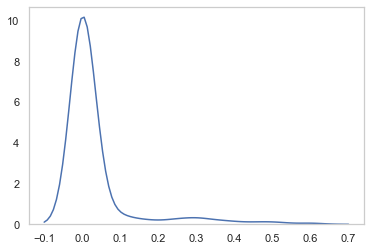

In [77]:
sns.kdeplot(y_pred);

In [78]:
metrics.confusion_matrix(y_test, y_pred > 0)

array([[175,  53],
       [  0,   5]])

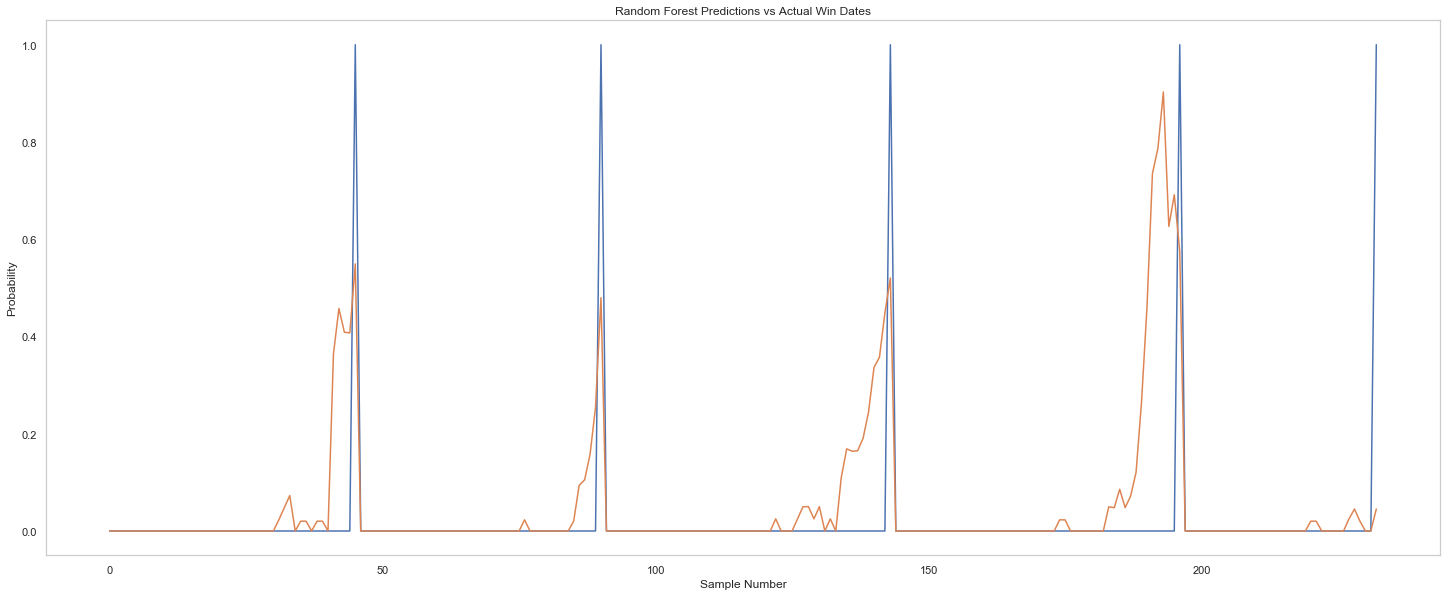

In [79]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(1.5*y_pred)
plt.tight_layout()
plt.title('Random Forest Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

---
### Gradient Boosted Trees

#### Grid search to find best parameters

In [95]:
# clf = HistGradientBoostingClassifier(random_state=42)

In [96]:
# # grid_p = {"learning_rate" : [0.05, 0.1, 0.15], # first run
# # grid_p = {"learning_rate" : [0.07, 0.1, 0.13], # second run
# grid_p = {"learning_rate" : [0.03, 0.05, 0.07], # third run
# #           "max_iter" : [100, 150], # first run
# #           "max_iter" : [150, 200], # second run
#           "max_iter" : [200, 225, 250], # third run
# #           "max_leaf_nodes" : [2**4-1, 2**5-1, 2**6-1], # first run
# #           "max_leaf_nodes" : [2**3-1, 2**4-1, 2**5-1], # second run
#           "max_leaf_nodes" : [2**2-1, 2**3-1, 2**4-1], # third run
# #           "max_bins" : [100, 150, 200], # first run, second run
#           "max_bins" : [125, 150, 175], # third run
# #           "l2_regularization" : [0.1, 0.5, 0.9]} # first run
# #           "l2_regularization" : [0.85, 0.9, 0.95]} # second run
#           "l2_regularization" : [0.82, 0.85, 0.88]} # third run

# grid_search = GridSearchCV(clf, grid_p, n_jobs=-1, cv=TimeSeriesSplit(), scoring='roc_auc')
# grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score=nan,
             estimator=HistGradientBoostingClassifier(l2_regularization=0.0,
                                                      learning_rate=0.1,
                                                      loss='auto', max_bins=255,
                                                      max_depth=None,
                                                      max_iter=100,
                                                      max_leaf_nodes=31,
                                                      min_samples_leaf=20,
                                                      n_iter_no_change=None,
                                                      random_state=42,
                                                      scoring=None, tol=1e-07,
                                                      validation_fraction=0.1,
                                                      verbose=0,
                

In [97]:
# grid_search.best_score_
# second run: 0.9613449913644214
# third run: 0.9648677677029361

0.9648677677029361

In [98]:
# grid_search.best_params_
# second run:
# {'l2_regularization': 0.85,
#  'learning_rate': 0.07,
#  'max_bins': 150,
#  'max_iter': 200,
#  'max_leaf_nodes': 7}

# third run:
# {'l2_regularization': 0.82,
#  'learning_rate': 0.03,
#  'max_bins': 150,
#  'max_iter': 225,
#  'max_leaf_nodes': 3}

{'l2_regularization': 0.82,
 'learning_rate': 0.03,
 'max_bins': 150,
 'max_iter': 225,
 'max_leaf_nodes': 3}

In [100]:
X_train, y_train = train[used_cols], train[target]

clf = HistGradientBoostingClassifier(loss='auto',
                                     random_state=42,
                                     learning_rate=0.03,
                                     max_iter=225,
                                     max_leaf_nodes=2**2-1,
                                     max_bins=150,
                                     l2_regularization=0.82)

scores = cross_validate(pipe, X_train, y_train, cv = TimeSeriesSplit(),
                        scoring=['f1', 'f1_weighted', 'precision', 'precision_weighted',
                                 'recall', 'recall_weighted', 'accuracy', 'roc_auc'])

print('f1:', scores['test_f1'].mean(), '+/-', scores['test_f1'].std())
print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision:', scores['test_precision'].mean(), '+/-', scores['test_precision'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall:', scores['test_recall'].mean(), '+/-', scores['test_recall'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

# the thing to beat: 0.9827072152653548 accuracy

f1: nan +/- nan
f1_weighted: nan +/- nan
precision: nan +/- nan
precision_weighted: nan +/- nan
recall: nan +/- nan
recall_weighted: nan +/- nan
accuracy: nan +/- nan
roc_auc: nan +/- nan


In [101]:
pipe.fit(X_train, y_train)
X_test = test[used_cols]
y_test = test[target]
y_pred = pipe.predict(X_test)

In [102]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Test set balanced_accuracy:', metrics.balanced_accuracy_score(y_test, y_pred))

Test set accuracy: 0.9570815450643777
Test set balanced_accuracy: 0.8802631578947369


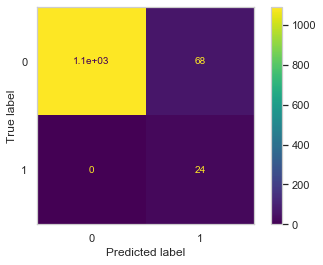

In [103]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

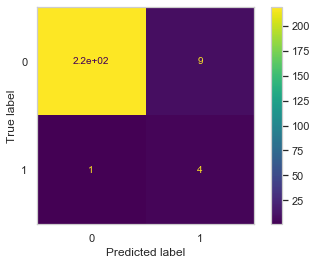

In [104]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [105]:
y_pred = rf.predict_proba(X_test)[:,1]
y_pred[:5]

array([0., 0., 0., 0., 0.])

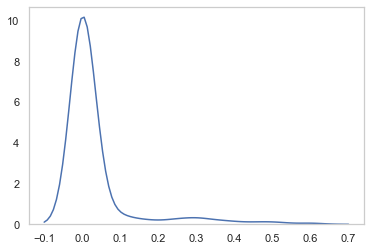

In [106]:
sns.kdeplot(y_pred);

In [107]:
metrics.confusion_matrix(y_test, y_pred > 0)

array([[175,  53],
       [  0,   5]])

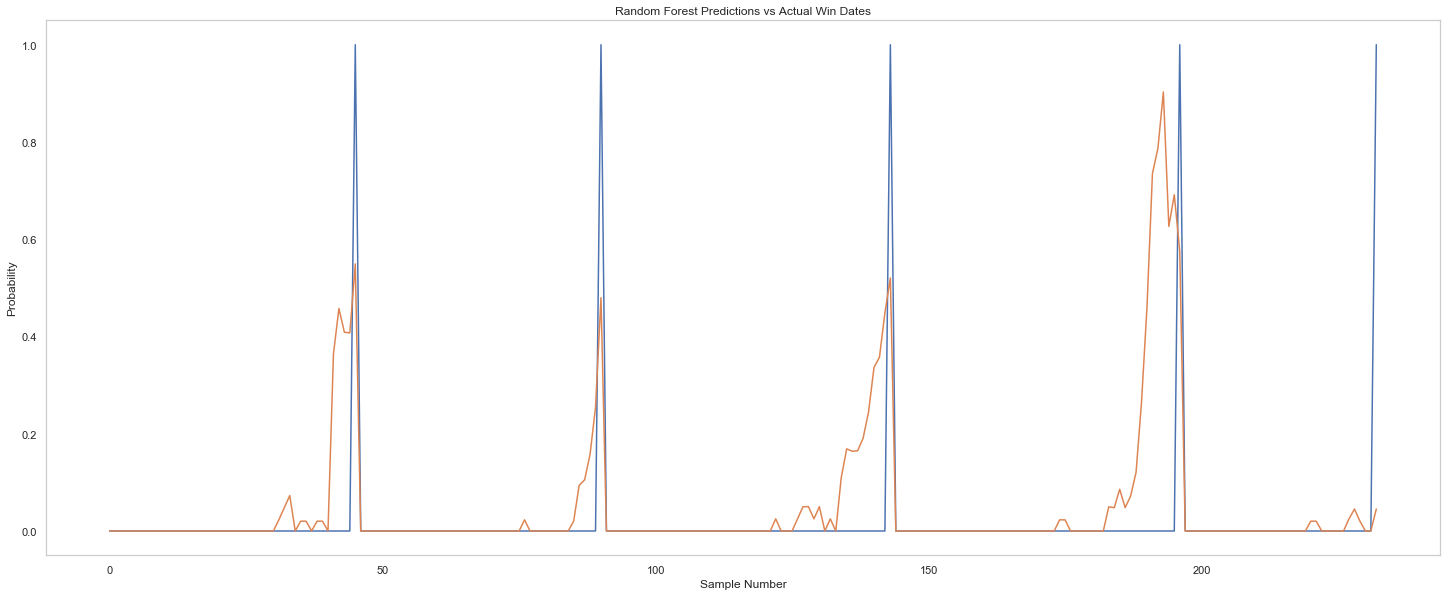

In [108]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(1.5*y_pred)
plt.tight_layout()
plt.title('HistGradientBoostingClassifier Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()